## HMMLearn in Python

* [HMMlearn Docs](https://hmmlearn.readthedocs.io/en/latest/)

Once you understand the basic ideas of Markov Chains, what can you do with it? Hidden Markov Models are fascinating in that it supposes that you have some data and the data comes from some underlying state that is unobserved (hidden) from you.

Another way of thinking of Hidden Markov Models are that they are a form of unsupervised learning for time series analysis. Given the data and a number of hidden states and assumptions into the underlying distribution, you can use libraries like python's `hmmlearn` to try to uncover the hidden states.

In [1]:
from hmmlearn import hmm
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

## A trivial example

We'll start with the simplest example in which we have data that comes from two different gaussian processes. 

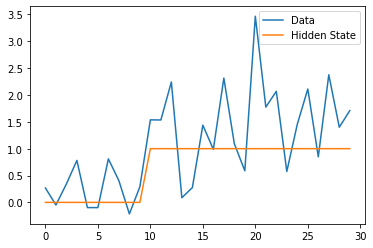

In [2]:
# randomly generate two series:
series1 = np.random.normal(0.02, 0.5, size=10)
series2 = np.random.normal(2, 1, size=20)

X = np.hstack([series1, series2]).reshape(-1,1) # must be a column vector
Z_true = np.hstack([np.zeros(10), np.ones(20)])

fig, ax = plt.subplots()
ax.plot(X, label="Data")
ax.plot(Z_true, label="Hidden State")
ax.legend()
plt.show()

The above code creates data where there is a clear transition from one state to another at the 10th point. We know this to be true because we made it up!

With this simple model, can we use a hidden markov model to detect the underlying state?

The `hmmlearn` library employs a similar syntax to `sklearn`, so you follow the familiar steps to instantiate a model, fit it on data with `.fit`, and predict with `.predict`:

In [3]:
# Instantitate the model class 
model = hmm.GaussianHMM(n_components=2)
# Fit and predict
model.fit(X)
Z = model.predict(X)
model.score(X)

-30.70522845012973

How well did this simple model perform? Since there are two underlying states (0 and 1) we can check the forecast accuracy as follows:

In [4]:
np.mean(Z == Z_true)

1.0

And lo and behold, it got a perfect result on this simplest of models. We can even get estimates of the means and covariance:

In [5]:
model.means_

array([[0.23953139],
       [1.54676947]])

In [6]:
model.covars_

array([[[0.11124402]],

       [[0.58902567]]])

Given the assumption that the underlying processes are Gaussian, we see that the means and variances are off from the true values, but it was correctly able to tell that the second state had a higher mean and higher variance than the other.

## Basic Usage

`hmmlearn` can also *instantiate* data, useful for learning and perhaps doing some prior predictive checks.

Here we instantiate a Gaussian HMM with 2 states:

In [7]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = np.array([[0.7, 0.3],
                            [0.2, 0.8]])
model.means_ = np.array([[0.2, 0.7], [0.02, -0.03]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
X, Z = model.sample(100)

Note that the $X$ array is now 2-dimensional.

Text(0.5, 0, 'X_2')

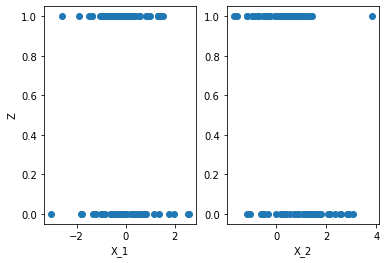

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], Z)
ax[0].set_ylabel("Z")
ax[0].set_xlabel("X_1")
ax[1].scatter(X[:,1], Z)
ax[1].set_xlabel("X_2")

In [9]:
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
remodel.fit(X)
Z2 = remodel.predict(X)

The parameters of the HMM process are estimated with the Baum Welch algorithm and estimate of the underlying states are found with the Viterbi algorithm.

* Baum Welch: [Wikipedia](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm)
* Viterbi: [Wikipedia](https://en.wikipedia.org/wiki/Viterbi_algorithm)

We can check convergence on the model with the `.monitor_` and `.monitor_.converged` attributes after fitting:

In [10]:
remodel.monitor_

ConvergenceMonitor(
    history=[-289.2975186516425, -281.49902894521415, -280.92921607423574, -280.6714699494103, -280.5221816422183, -280.4260709155556, -280.3598654223045, -280.3123248447629, -280.2771195955079, -280.2501946532629, -280.22878143421747, -280.21094981786945, -280.1953475849395, -280.1810227223016, -280.1672945019778, -280.15365810244435, -280.13971273859914, -280.125104953536, -280.10947917705096, -280.09242690298066, -280.0734229398671, -280.05172993677706, -280.0262356657242, -279.99514901500004, -279.9553899040767, -279.9012930730397, -279.8217717066677, -279.69443661177195, -279.4772384509725, -279.1174737130147, -278.6278489193005, -278.1432155376244, -277.77455440852236, -277.5189801100523, -277.33203650902885, -277.1825019063792, -277.0576096132107, -276.95380610503946, -276.86992722383945, -276.8043830672066, -276.7546851184474, -276.7178764730909, -276.69105805585275, -276.67171654064316, -276.6578411180106, -276.64790566608065],
    iter=46,
    n_iter=100,


In [11]:
remodel.monitor_.converged

True

Then - how well does it predict the underlying state?

In [12]:
# Accuracy
sum(Z2 == Z)/len(Z)

0.24

In [13]:
remodel.score(X)

-276.6407901301886

## Dishonest Casino Example

We’ll use the ubiquitous dishonest casino example to demonstrate how to train a Hidden Markov Model (HMM) on somewhat realistic test data (e.g. http://www.mcb111.org/w06/durbin_book.pdf Chapter 3).

In this example, we suspect that a casino is trading out a fair die (singular or dice) for a loaded die. We want to figure out 1) when the loaded die was used (i.e. the most likely path) 2) how often the loaded die is used (i.e. the transition probabilities) and 3) the probabilities for each outcome of a roll for the loaded die (i.e. the emission probabilities).

Now, let’s act as the casino and exchange a fair die for a loaded one and generate a series of rolls that someone at the casino would observe.

/var/folders/5p/b6cx3vmd09ncxtl64chdxsh40000gq/T/ipykernel_6367/2820131750.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/5p/b6cx3vmd09ncxtl64chdxsh40000gq/T/ipykernel_6367/2820131750.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


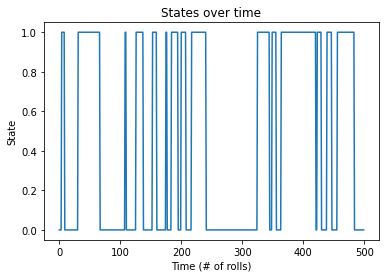

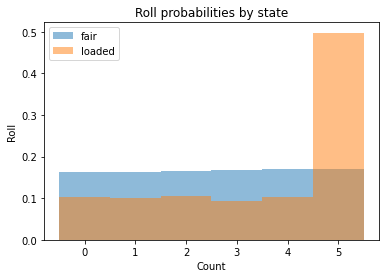

In [14]:
# make our generative model with two components, a fair die and a
# loaded die
gen_model = hmm.MultinomialHMM(n_components=2, random_state=99)

# the first state is the fair die so let's start there so no one
# catches on right away
gen_model.startprob_ = np.array([1.0, 0.0])

# now let's say that we sneak the loaded die in:
# here, we have a 95% chance to continue using the fair die and a 5%
# chance to switch to the loaded die
# when we enter the loaded die state, we have a 90% chance of staying
# in that state and a 10% chance of leaving
gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])

# now let's set the emission means:
# the first state is a fair die with equal probabilities and the
# second is loaded by being biased toward rolling a six
gen_model.emissionprob_ = \
    np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],
              [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()

Generated score: -26230.575868403906
Best score:      -26229.219361702373


/var/folders/5p/b6cx3vmd09ncxtl64chdxsh40000gq/T/ipykernel_6367/2862093247.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


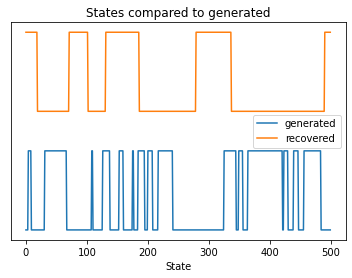

In [15]:
# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

# check optimal score
gen_score = gen_model.score(X_validate)

best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.MultinomialHMM(
        n_components=2, random_state=idx,
        init_params='se')  # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                                np.random.dirichlet([0.1, 0.9])])
    model.fit(X_train)
    score = model.score(X_validate)
    # print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {gen_score}\nBest score:      {best_score}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
fig.show()

Check the learned transition probabilities:

In [16]:
print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

Transmission Matrix Generated:
[[0.95 0.05]
 [0.1  0.9 ]]

Transmission Matrix Recovered:
[[0.922 0.078]
 [0.059 0.941]]




Check if the die are loaded

In [17]:
print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

Emission Matrix Generated:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.1   0.1   0.1   0.1   0.1   0.5  ]]

Emission Matrix Recovered:
[[0.106 0.108 0.114 0.105 0.113 0.454]
 [0.168 0.168 0.167 0.171 0.172 0.153]]


